In [1]:

import os
import pickle
from pathlib import Path

import catboost
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
from tqdm.auto import tqdm

from lfm import calc_embeddings, calc_scores
from metric import apk, mapk
from utils import plot_images

ARTIFACTS_DIR = Path('artifacts')
ARTIFACTS_DIR.mkdir(exist_ok=True)

dataset = '10'


def objective(trial):

    transactions = pd.read_pickle(f"input/{dataset}/transactions_train.pkl")
    users = pd.read_pickle(f"input/{dataset}/users.pkl")
    items = pd.read_pickle(f"input/{dataset}/items.pkl")

    class CFG:
        model_type = 'CatBoost'
        popular_num_items = trial.suggest_int('popular_num_items', 12, 48)
        popular_days = trial.suggest_int('popular_days', 5, 9)
        train_weeks = trial.suggest_int('train_weeks', 2, 2)
        repurchase_weeks = 12345
        repurchase_num_items = 12345
        item2item_weeks = 12345
        item2item_num_items = trial.suggest_int('item2item_num_items', 12, 36)
        cooc_weeks = trial.suggest_int('cooc_weeks', 10, 14)
        cooc_threshold = trial.suggest_int('cooc_threshold', 4, 6)
        dynamic_feature_weeks = trial.suggest_int('dynamic_feature_weeks', 6, 10)
        volume_feature_days = trial.suggest_int('volume_feature_days', 5, 9)

    cooc_new_pattern = trial.suggest_categorical('cooc_new_pattern', [False, True])

    lfm_emb_type = trial.suggest_categorical('lfm_emb_type', ['i_i', 'if_i', 'if_f', 'if_if'])
    lfm_emb_dim = trial.suggest_categorical('lfm_emb_dim', [8, 16, 32])
    lfm_score_type = trial.suggest_categorical('lfm_score_type', ['None', 'i_i', 'if_i', 'if_f', 'if_if'])
    lfm_score_dim = trial.suggest_categorical('lfm_score_dim', [8, 16, 32])

    garment_group_no = trial.suggest_categorical('garment_group_no', [False, True])
    product_type_no = trial.suggest_categorical('product_type_no', [False, True])
    product_group_name = trial.suggest_categorical('product_group_name', [False, True])
    graphical_appearance_no = trial.suggest_categorical('graphical_appearance_no', [False, True])
    colour_group_code = trial.suggest_categorical('colour_group_code', [False, True])
    perceived_colour_value_id = trial.suggest_categorical('perceived_colour_value_id', [False, True])
    perceived_colour_master_id = trial.suggest_categorical('perceived_colour_master_id', [False, True])
    department_no = trial.suggest_categorical('department_no', [False, True])
    index_code = trial.suggest_categorical('index_code', [False, True])
    index_group_no = trial.suggest_categorical('index_group_no', [False, True])
    section_no = trial.suggest_categorical('section_no', [False, True])

    def create_candidates(transactions: pd.DataFrame, target_users: np.ndarray, week: int) -> pd.DataFrame:
        """
        transactions
            original transactions (user, item, week)
        target_users, week
            候補生成対象のユーザー
            weekで指定されている週の段階での情報のみから作られる
        """
        assert len(target_users) == len(set(target_users))

        def create_candidates_repurchase(
                strategy: str,
                transactions: pd.DataFrame,
                target_users: np.ndarray,
                week_start: int,
                num_weeks: int,
                max_items_per_user: int) -> pd.DataFrame:
            week_end = week_start + num_weeks
            tr = transactions.query("user in @target_users and @week_start <= week < @week_end")[
                ['user', 'item', 'week', 'day']].drop_duplicates(ignore_index=True)

            gr_day = tr.groupby(['user', 'item'])['day'].min().reset_index(name='day')
            gr_week = tr.groupby(['user', 'item'])['week'].min().reset_index(name='week')
            gr_volume = tr.groupby(['user', 'item']).size().reset_index(name='volume')

            gr_day['day_rank'] = gr_day.groupby('user')['day'].rank()
            gr_week['week_rank'] = gr_week.groupby('user')['week'].rank()
            gr_volume['volume_rank'] = gr_volume.groupby('user')['volume'].rank(ascending=False)

            candidates = gr_day.merge(gr_week, on=['user', 'item']).merge(gr_volume, on=['user', 'item'])

            candidates['rank_meta'] = 10**9 * candidates['day_rank'] + candidates['volume_rank']
            candidates['rank_meta'] = candidates.groupby('user')['rank_meta'].rank(method='min')
            # item2itemに使う場合は全件使うと無駄に重くなってしまうので削る
            # dayの小ささ, volumeの大きさの辞書順にソートして上位アイテムのみ残す
            # 全部残したい場合はmax_items_per_userに十分大きな数を指定する
            candidates = candidates.query("rank_meta <= @max_items_per_user").reset_index(drop=True)

            candidates = candidates[['user', 'item', 'week_rank', 'volume_rank', 'rank_meta']].rename(
                columns={'week_rank': f'{strategy}_week_rank', 'volume_rank': f'{strategy}_volume_rank'})

            candidates['strategy'] = strategy
            return candidates.drop_duplicates(ignore_index=True)

        def create_candidates_popular(
            strategy: str,
            transactions: pd.DataFrame,
            target_users: np.ndarray,
            week_start: int,
        ) -> pd.DataFrame:
            day_start = 7 * week_start
            tr = transactions.query(
                "@day_start <= day < @day_start + @CFG.popular_days")[['user', 'item']].drop_duplicates(ignore_index=True)
            popular_items = tr['item'].value_counts().index.values[:CFG.popular_num_items]
            popular_items = pd.DataFrame({
                'item': popular_items,
                'rank': range(CFG.popular_num_items),
                'crossjoinkey': 1,
            })

            candidates = pd.DataFrame({
                'user': target_users,
                'crossjoinkey': 1,
            })

            candidates = candidates.merge(popular_items, on='crossjoinkey').drop('crossjoinkey', axis=1)
            candidates = candidates.rename(columns={'rank': f'{strategy}_rank'})

            candidates['strategy'] = strategy
            return candidates.drop_duplicates(ignore_index=True)

        def create_candidates_cooc(
                strategy: str,
                transactions: pd.DataFrame,
                week_start: int,
                week_num: int,
                base_candidates: pd.DataFrame) -> pd.DataFrame:
            week_end = week_start + week_num
            if not cooc_new_pattern:
                tr = transactions.query(
                    "@week_start <= week < @week_end")[['user', 'item', 'week']].drop_duplicates(ignore_index=True)
                tr = tr.merge(tr.rename(columns={'item': 'item_with', 'week': 'week_with'}), on='user').query(
                    "item != item_with and week <= week_with")[['item', 'item_with']].reset_index(drop=True)
                gr_sz = tr.groupby('item').size().reset_index(name='tot')
                gr_cnt = tr.groupby(['item', 'item_with']).size().reset_index(name='cnt')
                item2item = gr_cnt.merge(gr_sz, on='item')
                item2item['ratio'] = item2item['cnt'] / item2item['tot']
                aba = CFG.cooc_threshold
                item2item = item2item.query("cnt > @aba").reset_index(drop=True)

                candidates = base_candidates.merge(item2item, on='item').drop(
                    ['item', 'cnt'], axis=1).rename(columns={'item_with': 'item'})
                base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
                base_candidates_replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
                candidates = candidates.rename(columns=base_candidates_replace)
                candidates = candidates.rename(columns={'ratio': f'{strategy}_ratio', 'tot': f'{strategy}_tot'})

                candidates['strategy'] = strategy

            else:
                tr = transactions.query("@week_start <= week < @week_end")[['user', 'item']].drop_duplicates(ignore_index=True)
                tr = tr.merge(tr.rename(columns={'item': 'item_with'}), on='user').query("item != item_with")[['item', 'item_with']].reset_index(drop=True)
                gr_sz = tr.groupby('item').size().reset_index(name='tot')
                gr_cnt = tr.groupby(['item', 'item_with']).size().reset_index(name='cnt')
                item2item = gr_cnt.merge(gr_sz, on='item')
                item2item['ratio'] = item2item['cnt'] / item2item['tot']
                item2item = item2item.query("cnt > @CFG.cooc_threshold").reset_index(drop=True)

                candidates = base_candidates.merge(item2item, on='item').drop(
                    ['item', 'cnt'], axis=1).rename(columns={'item_with': 'item'})
                base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
                base_candidates_replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
                candidates = candidates.rename(columns=base_candidates_replace)
                candidates = candidates.rename(columns={'ratio': f'{strategy}_ratio', 'tot': f'{strategy}_tot'})

                candidates['strategy'] = strategy
            return candidates.drop_duplicates(ignore_index=True)

        def create_candidates_same_product_code(
                strategy: str,
                items: pd.DataFrame,
                base_candidates: pd.DataFrame) -> pd.DataFrame:
            item2item = items[['item', 'product_code']].merge(items[['item', 'product_code']].rename(
                {'item': 'item_with'}, axis=1), on='product_code')[['item', 'item_with']].query("item != item_with").reset_index(drop=True)

            candidates = base_candidates.merge(item2item, on='item').drop('item', axis=1).rename(columns={'item_with': 'item'})

            candidates['min_rank_meta'] = candidates.groupby(['user', 'item'])['rank_meta'].transform('min')
            candidates = candidates.query("rank_meta == min_rank_meta").reset_index(drop=True)

            base_candidates_columns = [c for c in base_candidates.columns if '_' in c]
            base_candidates_replace = {c: f"{strategy}_{c}" for c in base_candidates_columns}
            candidates = candidates.rename(columns=base_candidates_replace)

            candidates['strategy'] = strategy
            return candidates.drop_duplicates(ignore_index=True)

        candidates_repurchase = create_candidates_repurchase(
            'repurchase',
            transactions,
            target_users,
            week,
            CFG.repurchase_weeks,
            CFG.repurchase_num_items)
        candidates_popular = create_candidates_popular('pop', transactions, target_users, week)

        candidates_item2item = create_candidates_repurchase(
            'item2item',
            transactions,
            target_users,
            week,
            CFG.repurchase_weeks,
            CFG.item2item_num_items)
        candidates_cooc = create_candidates_cooc('cooc', transactions, week, CFG.cooc_weeks, candidates_item2item)
        candidates_same_product_code = create_candidates_same_product_code('same_product_code', items, candidates_item2item)

        def drop_common_user_item(candidates_target: pd.DataFrame, candidates_reference: pd.DataFrame) -> pd.DataFrame:
            """
            candidates_targetのうちuser, itemの組がcandidates_referenceにあるものを落とす
            """
            tmp = candidates_reference[['user', 'item']].reset_index(drop=True)
            tmp['flag'] = 1
            candidates = candidates_target.merge(tmp, on=['user', 'item'], how='left')
            return candidates.query("flag != 1").reset_index(drop=True).drop('flag', axis=1)

        candidates_cooc = drop_common_user_item(candidates_cooc, candidates_repurchase)
        candidates_same_product_code = drop_common_user_item(candidates_same_product_code, candidates_repurchase)

        candidates = [
            candidates_repurchase,
            candidates_popular,
            candidates_cooc,
            candidates_same_product_code,
        ]
        candidates = pd.concat(candidates)

        volumes = candidates.groupby('strategy').size().reset_index(
            name='volume').sort_values(
            by='volume',
            ascending=False).reset_index(
            drop=True)
        volumes['ratio'] = volumes['volume'] / volumes['volume'].sum()

        meta_columns = [c for c in candidates.columns if c.endswith('_meta')]
        return candidates.drop(meta_columns, axis=1)

    # %%
    # valid: week=0
    # train: week=1..CFG.train_weeks
    candidates = []
    for week in range(1 + CFG.train_weeks):
        target_users = transactions.query("week == @week")['user'].unique()
        candidates.append(create_candidates(transactions, target_users, week + 1))

    # %%
    def merge_labels(candidates: pd.DataFrame, week: int) -> pd.DataFrame:
        """
        candidatesに対してweekで指定される週のトランザクションからラベルを付与する
        """
        labels = transactions[transactions['week'] == week][['user', 'item']].drop_duplicates(ignore_index=True)
        labels['y'] = 1
        original_positives = len(labels)
        labels = candidates.merge(labels, on=['user', 'item'], how='left')
        labels['y'] = labels['y'].fillna(0)

        remaining_positives_total = labels[['user', 'item', 'y']].drop_duplicates(ignore_index=True)['y'].sum()
        recall = remaining_positives_total / original_positives

        volumes = candidates.groupby('strategy').size().reset_index(name='volume')
        remaining_positives = labels.groupby('strategy')['y'].sum().reset_index()
        remaining_positives = remaining_positives.merge(volumes, on='strategy')
        remaining_positives['recall'] = remaining_positives['y'] / original_positives
        remaining_positives['hit_ratio'] = remaining_positives['y'] / remaining_positives['volume']
        remaining_positives = remaining_positives.sort_values(by='y', ascending=False).reset_index(drop=True)

        return labels

    # %%
    for idx in range(len(candidates)):
        candidates[idx] = merge_labels(candidates[idx], idx)

    # %%

    def drop_trivial_users(labels):
        """
        LightGBMのxendgcやlambdarankでは正例のみや負例のみのuserは学習に無意味なのと、メトリックの計算がおかしくなるので省く
        """
        bef = len(labels)
        df = labels[labels['user'].isin(labels[['user', 'y']].drop_duplicates().groupby(
            'user').size().reset_index(name='sz').query("sz==2").user)].reset_index(drop=True)
        aft = len(df)
        return df

    for idx in range(len(candidates)):
        candidates[idx]['week'] = idx

    candidates_valid_all = candidates[0].copy()

    for idx in range(len(candidates)):
        candidates[idx] = drop_trivial_users(candidates[idx])

    # %%

    def attach_features(
            transactions: pd.DataFrame,
            users: pd.DataFrame,
            items: pd.DataFrame,
            candidates: pd.DataFrame,
            week: int,
            pretrain_week: int) -> pd.DataFrame:
        """
        user, itemに対して特徴を横付けする
        week: これを含めた以前の情報は使って良い
        """
        n_original = len(candidates)
        df = candidates.copy()

        # user static features
        user_features = ['FN', 'Active', 'age', 'club_member_status_idx', 'fashion_news_frequency_idx']
        df = df.merge(users[['user'] + user_features], on='user')

        # item static features
        item_features = [c for c in items.columns if c.endswith('idx')]
        df = df.merge(items[['item'] + item_features], on='item')

        # user dynamic features (transactions)
        week_end = week + CFG.dynamic_feature_weeks
        tmp = transactions.query(
            "@week <= week < @week_end").groupby('user')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['user_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='user', how='left')

        # item dynamic features (transactions)
        week_end = week + CFG.dynamic_feature_weeks
        tmp = transactions.query(
            "@week <= week < @week_end").groupby('item')[['price', 'sales_channel_id']].agg(['mean', 'std'])
        tmp.columns = ['item_' + '_'.join(a) for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

        # item dynamic features (user features)
        week_end = week + CFG.dynamic_feature_weeks
        tmp = transactions.query("@week <= week < @week_end").merge(users[['user', 'age']], on='user')
        tmp = tmp.groupby('item')['age'].agg(['mean', 'std'])
        tmp.columns = [f'age_{a}' for a in tmp.columns.to_flat_index()]
        df = df.merge(tmp, on='item', how='left')

        # item freshness features
        tmp = transactions.query("@week <= week").groupby('item')['day'].min().reset_index(name='item_day_min')
        tmp['item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on='item', how='left')

        # item volume features
        day_start = 7 * week
        day_end = day_start + CFG.volume_feature_days
        tmp = transactions.query("@day_start <= day < @day_end").groupby('item').size().reset_index(name='item_volume')
        df = df.merge(tmp, on='item', how='left')

        # user-item freshness features
        tmp = transactions.query("@week <= week").groupby(['user', 'item'])['day'].min().reset_index(name='user_item_day_min')
        tmp['user_item_day_min'] -= transactions.query("@week == week")['day'].min()
        df = df.merge(tmp, on=['item', 'user'], how='left')

        # user-item volume features
        day_start = 7 * week
        day_end = day_start + CFG.volume_feature_days
        tmp = transactions.query(
            "@day_start <= day < @day_end").groupby(['user', 'item']).size().reset_index(name='user_item_volume')
        df = df.merge(tmp, on=['user', 'item'], how='left')

        # lfm features
        user_reps, _ = calc_embeddings(lfm_emb_type, dataset, pretrain_week, lfm_emb_dim)
        df = df.merge(user_reps, on='user')

        if lfm_score_type != 'None':
            df['lfm'] = calc_scores(lfm_score_type, dataset, pretrain_week, lfm_score_dim, df['user'].values, df['item'].values)

        prefix = f'artifacts/user_features/user_ohe_agg_dataset{dataset}_week{week}'
        if garment_group_no:
            df = df.merge(pd.read_pickle(f'{prefix}_garment_group_no_idx.pkl'), on='user')
        if product_type_no:
            df = df.merge(pd.read_pickle(f'{prefix}_product_type_no_idx.pkl'), on='user')
        if product_group_name:
            df = df.merge(pd.read_pickle(f'{prefix}_product_group_name_idx.pkl'), on='user')
        if graphical_appearance_no:
            df = df.merge(pd.read_pickle(f'{prefix}_graphical_appearance_no_idx.pkl'), on='user')
        if colour_group_code:
            df = df.merge(pd.read_pickle(f'{prefix}_colour_group_code_idx.pkl'), on='user')
        if perceived_colour_value_id:
            df = df.merge(pd.read_pickle(f'{prefix}_perceived_colour_value_id_idx.pkl'), on='user')
        if perceived_colour_master_id:
            df = df.merge(pd.read_pickle(f'{prefix}_perceived_colour_master_id_idx.pkl'), on='user')
        if department_no:
            df = df.merge(pd.read_pickle(f'{prefix}_department_no_idx.pkl'), on='user')
        if index_code:
            df = df.merge(pd.read_pickle(f'{prefix}_index_code_idx.pkl'), on='user')
        if index_group_no:
            df = df.merge(pd.read_pickle(f'{prefix}_index_group_no_idx.pkl'), on='user')
        if section_no:
            df = df.merge(pd.read_pickle(f'{prefix}_section_no_idx.pkl'), on='user')

        assert len(df) == n_original
        return df

    dataset_valid_all = attach_features(transactions, users, items, candidates_valid_all, 1, CFG.train_weeks + 1)
    # pretrained modelの学習期間が評価時と提出時で異なるので、candidatesは残しておく
    datasets = [
        attach_features(
            transactions,
            users,
            items,
            candidates[idx],
            1 +
            idx,
            CFG.train_weeks +
            1) for idx in range(
            len(candidates))]

    # %%
    for idx in range(len(datasets)):
        datasets[idx]['query_group'] = datasets[idx]['week'].astype(str) + '_' + datasets[idx]['user'].astype(str)
        datasets[idx] = datasets[idx].sort_values(by='query_group').reset_index(drop=True)

    # %%
    def concat_train(datasets, begin, num):
        train = pd.concat([datasets[idx] for idx in range(begin, begin + num)])
        return train

    valid = datasets[0]
    train = concat_train(datasets, 1, CFG.train_weeks)

    feature_columns = [c for c in valid.columns if c not in ['y', 'strategy', 'query_group', 'week']]

    cat_feature_values = [c for c in feature_columns if c.endswith('idx')]
    cat_features = [feature_columns.index(c) for c in cat_feature_values]

    train_pool = catboost.Pool(
        data=train[feature_columns],
        label=train['y'],
        group_id=train['query_group'],
        cat_features=cat_features)
    valid_pool = catboost.Pool(
        data=valid[feature_columns],
        label=valid['y'],
        group_id=valid['query_group'],
        cat_features=cat_features)

    params = {
        'loss_function': 'YetiRank',
        'use_best_model': True,
        'one_hot_max_size': 300,
        'learning_rate': 0.1,
        'verbose': False,
    }
    model = catboost.CatBoost(params)
    model.fit(train_pool, eval_set=valid_pool)

    feature_importance = model.get_feature_importance(train_pool)
    sorted_idx = np.argsort(feature_importance)
    plt.figure(figsize=(8, 16))
    plt.yticks(range(len(feature_columns)), np.array(feature_columns)[sorted_idx])
    plt.barh(range(len(feature_columns)), feature_importance[sorted_idx])

    # %%
    pred = dataset_valid_all[['user', 'item']].reset_index(drop=True)
    pred['pred'] = model.predict(dataset_valid_all[feature_columns])

    # %%
    pred = pred.groupby(['user', 'item'])['pred'].max().reset_index()
    pred = pred.sort_values(by=['user', 'pred'], ascending=False).reset_index(
        drop=True).groupby('user')['item'].apply(lambda x: list(x)[:12]).reset_index()

    # %%
    gt = transactions.query("week == 0").groupby('user')['item'].apply(list).reset_index().rename(columns={'item': 'gt'})
    merged = gt.merge(pred, on='user', how='left')
    merged['item'] = merged['item'].fillna('').apply(list)

    return mapk(merged['gt'], merged['item'])

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, timeout=3600 * 12)

In [3]:
study.trials_dataframe().sort_values(by='value', ascending=False).reset_index(drop=True).to_csv('tuna.csv', index=False)

with open("study.pkl", 'wb') as f:
    pickle.dump(study, f)

In [15]:
pd.options.display.max_columns = 100
df = study.trials_dataframe().sort_values(by='value', ascending=False).reset_index(drop=True)
df

,number,value,datetime_start,datetime_complete,duration,params_colour_group_code,params_cooc_new_pattern,params_cooc_threshold,params_cooc_weeks,params_department_no,params_dynamic_feature_weeks,params_garment_group_no,params_graphical_appearance_no,params_index_code,params_index_group_no,params_item2item_num_items,params_lfm_emb_dim,params_lfm_emb_type,params_lfm_score_dim,params_lfm_score_type,params_perceived_colour_master_id,params_perceived_colour_value_id,params_popular_days,params_popular_num_items,params_product_group_name,params_product_type_no,params_section_no,params_train_weeks,params_volume_feature_days,state
0,60,0.031161,2022-04-17 03:46:50.426262,2022-04-17 03:51:55.924583,0 days 00:05:05.498321,True,False,5,12,True,6,True,False,True,False,17,8,if_if,8,if_if,False,True,5,38,False,False,False,2,9,COMPLETE
1,61,0.031161,2022-04-17 03:51:55.926259,2022-04-17 03:57:01.360024,0 days 00:05:05.433765,True,False,5,12,True,6,True,False,True,False,17,8,if_if,8,if_if,False,True,5,38,False,False,False,2,9,COMPLETE
2,65,0.031118,2022-04-17 04:13:00.783712,2022-04-17 04:18:15.686350,0 days 00:05:14.902638,True,False,5,12,True,6,True,False,True,False,19,8,if_if,8,if_if,False,True,5,36,False,False,False,2,9,COMPLETE
3,123,0.031118,2022-04-17 09:23:42.815450,2022-04-17 09:28:57.934885,0 days 00:05:15.119435,True,False,5,12,True,6,True,False,True,False,19,8,if_if,8,if_if,False,True,5,36,False,False,False,2,9,COMPLETE
4,74,0.031118,2022-04-17 05:00:14.169704,2022-04-17 05:05:32.786143,0 days 00:05:18.616439,True,False,5,12,True,6,True,False,True,False,19,8,if_if,8,if_if,False,True,5,36,False,False,False,2,9,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134,37,0.029072,2022-04-17 01:48:26.333012,2022-04-17 01:54:25.433705,0 days 00:05:59.100693,False,True,6,12,True,7,False,True,True,False,21,16,i_i,8,if_f,False,True,8,38,False,True,True,2,8,COMPLETE
135,47,0.029044,2022-04-17 02:41:10.029454,2022-04-17 02:44:38.441336,0 days 00:03:28.411882,True,False,4,11,False,9,False,False,False,True,17,32,i_i,16,if_if,True,False,6,28,False,False,False,2,8,COMPLETE
136,9,0.028985,2022-04-16 23:39:36.778589,2022-04-16 23:44:35.418068,0 days 00:04:58.639479,False,False,4,13,False,10,True,False,True,True,15,32,if_i,32,if_i,True,False,9,37,True,True,True,2,7,COMPLETE
137,7,0.028632,2022-04-16 23:28:31.897970,2022-04-16 23:34:51.188015,0 days 00:06:19.290045,True,False,5,11,True,10,False,False,True,False,35,32,if_if,8,i_i,True,True,8,27,True,False,False,2,6,COMPLETE


In [24]:
a = [c for c in df.columns if c.startswith('params_')]
a = [c[7:] for c in a]
a.remove('train_weeks')
print(a)

['colour_group_code', 'cooc_new_pattern', 'cooc_threshold', 'cooc_weeks', 'department_no', 'dynamic_feature_weeks', 'garment_group_no', 'graphical_appearance_no', 'index_code', 'index_group_no', 'item2item_num_items', 'lfm_emb_dim', 'lfm_emb_type', 'lfm_score_dim', 'lfm_score_type', 'perceived_colour_master_id', 'perceived_colour_value_id', 'popular_days', 'popular_num_items', 'product_group_name', 'product_type_no', 'section_no', 'volume_feature_days']


In [25]:
optuna.visualization.plot_param_importances(study, params=a)

In [27]:
optuna.visualization.plot_contour(study, params=['popular_num_items', 'popular_days', 'volume_feature_days', 'cooc_weeks'])

- cooc_weeks: 12のまま
- popular_days: 7 -> 5
- popular_num_items: 12 -> 36
- volume_feature_days: 7 -> 9 (もっとデカいかも)

In [29]:
cols = [
 'cooc_new_pattern',
 'colour_group_code',
 'department_no',
 'garment_group_no',
 'graphical_appearance_no',
 'index_code',
 'index_group_no',
 'perceived_colour_master_id',
 'perceived_colour_value_id',
 'product_group_name',
 'product_type_no',
 'section_no',
 'lfm_emb_dim',
 'lfm_emb_type',
 'lfm_score_dim',
 'lfm_score_type',
]

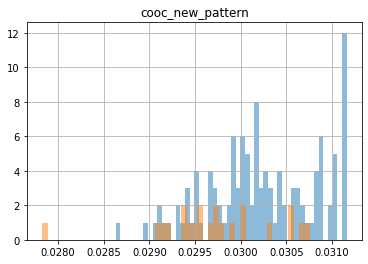

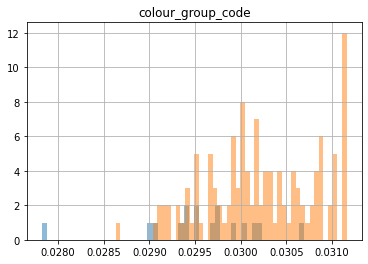

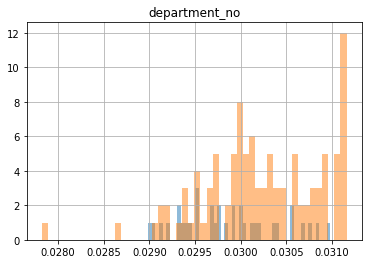

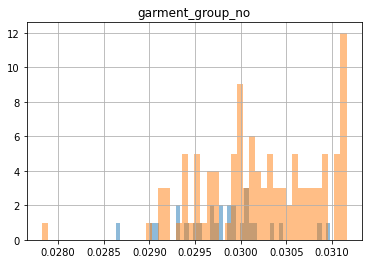

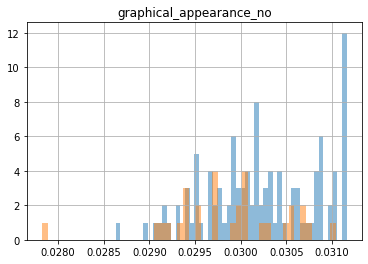

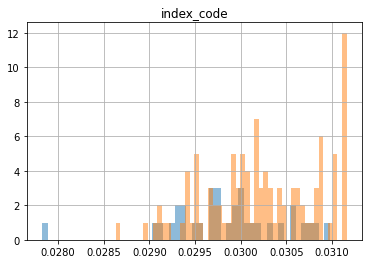

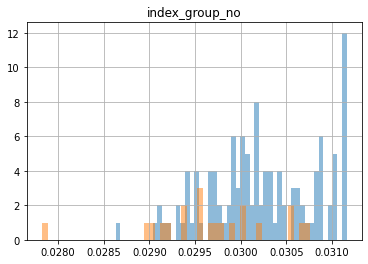

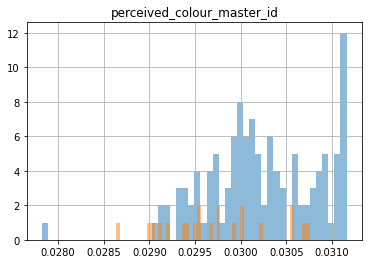

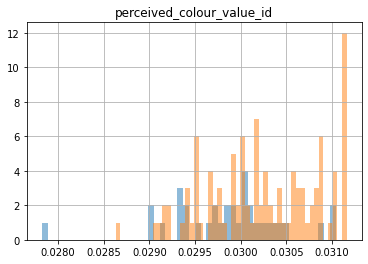

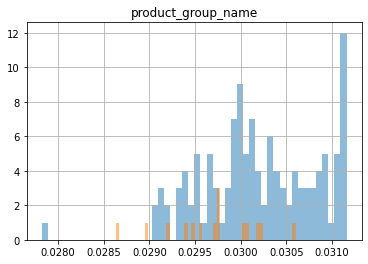

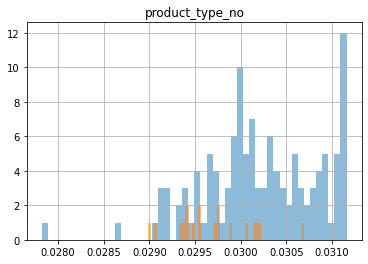

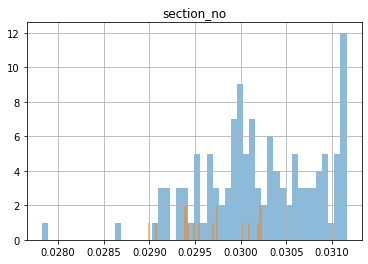

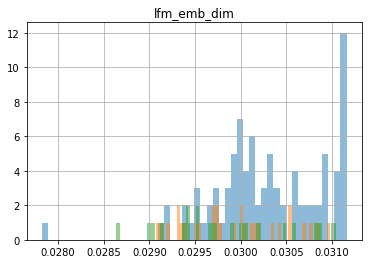

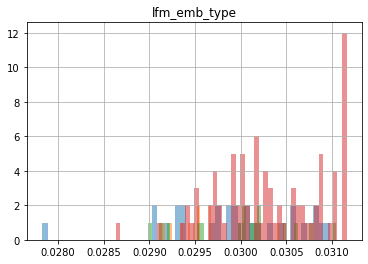

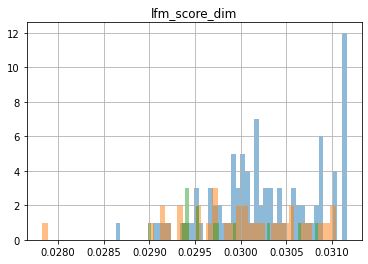

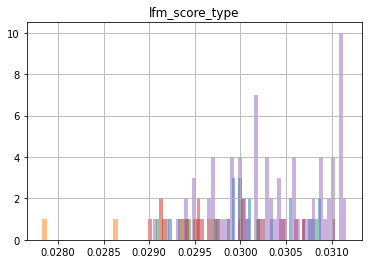

In [41]:
for col in cols:
    plt.title(col)
    df.groupby(f"params_{col}")['value'].hist(alpha=0.5, bins=50)
    plt.show()